<h1 style="color:yellow;">Concurrent Data - Machine Learning</h1>

# Imports

In [1]:
import numpy as np
import os
import sys
import time

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
from utils import print_evaluation_metrics, create_dataloaders, train_and_evaluate_pytorch_model, log_metrics, plot_individual_metrics

# Load the dataframes

In [2]:

# 1. Define the directory where your data is saved
save_dir = os.path.join('..', 'data frames', 'main','20 features')

# 2. Load the feature matrices (X)
X_train_processed = np.load(os.path.join(save_dir, 'X_train_processed.npy'))
X_val_processed = np.load(os.path.join(save_dir, 'X_val_processed.npy'))
X_test_processed = np.load(os.path.join(save_dir, 'X_test_processed.npy'))

# 3. Load the target vectors (y)
y_train_processed = np.load(os.path.join(save_dir, 'y_train_processed.npy'))
y_val_processed = np.load(os.path.join(save_dir, 'y_val_processed.npy'))
y_test_processed = np.load(os.path.join(save_dir, 'y_test_processed.npy'))

# 4. Load the label encoder classes
label_classes = np.load(os.path.join(save_dir, 'label_classes.npy'), allow_pickle=True)

print("All datasets loaded successfully.")

All datasets loaded successfully.


In [3]:
from sklearn.preprocessing import LabelEncoder

# Reconstruct the encoder from the saved classes
output_encoder = LabelEncoder()
output_encoder.classes_ = label_classes
output_encoder.fit(label_classes) # Sometimes needed to initialize internal dicts

print(f"Encoder restored. Classes: {output_encoder.classes_}")

Encoder restored. Classes: ['Benign' 'HTTPFlood' 'ICMPFlood' 'SYNFlood' 'SYNScan' 'SlowrateDoS'
 'TCPConnectScan' 'UDPFlood' 'UDPScan']


# Arguments

In [4]:
version = '20F'
model_results= []
results_dir = os.path.join('figures', 'results')
evaluation_dir = os.path.join('figures','evaluatoin charts')

# Machine Learning

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.utils.class_weight import compute_sample_weight


## Logistic Regression

In [6]:
linear_model = LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced', random_state=42)

start_time = time.time()
linear_model.fit(X_train_processed, y_train_processed)
training_time = time.time() - start_time

start_time = time.time()
y_pred_lr = linear_model.predict(X_val_processed)
prediction_time = time.time() - start_time

Logistic Regression Evaluation:
Accuracy: 0.93849671
Precision: 0.94615631
Recall: 0.93849671
F1 Score: 0.94082337
Training Time: 210.2970 seconds
Prediction Time: 0.0040 seconds
latency per sample: 0.00000003 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.95674012 0.93605320 0.94628361     47821
     HTTPFlood  0.95907143 0.95811332 0.95859213     14014
     ICMPFlood  0.28110599 1.00000000 0.43884892       122
      SYNFlood  0.97912088 0.87352941 0.92331606      1020
       SYNScan  0.99650873 0.99501992 0.99576377      2008
   SlowrateDoS  0.90728909 0.96451345 0.93502654      7214
TCPConnectScan  0.87740492 0.99593702 0.93292103      1969
      UDPFlood  0.95444612 0.92522221 0.93960699     45789
       UDPScan  0.51392405 0.99631902 0.67807933      1630

      accuracy                      0.93849671    121587
     macro avg  0.82506793 0.96052306 0.86093760    121587
  weighted avg  0.94615631 0.93849671 0.94082337    

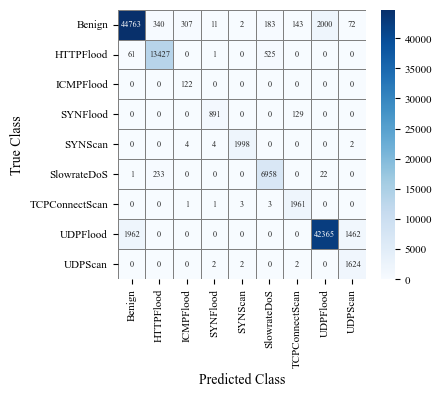

In [7]:
# arguments for evaluation function
results_file_name = 'logistic_regression_results.txt'
cm_title = 'Logistic Regression Confusion Matrix'

print("Logistic Regression Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_lr, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'logistic_regression', accuracy, precision, recall, f1, training_time, prediction_time)

## Random Forest

In [8]:
rnd_forest = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs = -1, class_weight='balanced')
start_time = time.time()
rnd_forest.fit(X_train_processed, y_train_processed)
training_time = time.time() - start_time

start_time = time.time()
y_pred_rf = rnd_forest.predict(X_val_processed)
prediction_time = time.time() - start_time

Evaluation:
Accuracy: 0.97896157
Precision: 0.97896172
Recall: 0.97896157
F1 Score: 0.97896133
Training Time: 10.2055 seconds
Prediction Time: 0.1070 seconds
latency per sample: 0.00000088 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.97394831 0.97409088 0.97401959     47821
     HTTPFlood  0.99693732 0.99878693 0.99786127     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  1.00000000 1.00000000 1.00000000      1020
       SYNScan  0.99651914 0.99800797 0.99726300      2008
   SlowrateDoS  0.99763495 0.99403937 0.99583391      7214
TCPConnectScan  0.99898271 0.99746064 0.99822109      1969
      UDPFlood  0.97293696 0.97278822 0.97286259     45789
       UDPScan  0.99754601 0.99754601 0.99754601      1630

      accuracy                      0.97896157    121587
     macro avg  0.99272282 0.99252445 0.99262305    121587
  weighted avg  0.97896172 0.97896157 0.97896133    121587



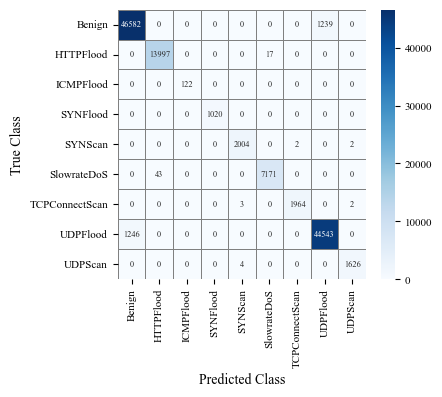

In [9]:
# arguments for evaluation function
model_type = 'random_forest'
results_file_name = 'random_forest_results.txt'
cm_title = 'Random Forest Confusion Matrix'

print("Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_rf, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'random_forest', accuracy, precision, recall, f1, training_time, prediction_time)

## XGBoost

In [10]:
# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(output_encoder.classes_), eval_metric='mlogloss')

# Train the model
start_time = time.time()
xgb_model.fit(X_train_processed, y_train_processed,)
training_time = time.time() - start_time

# Make predictions
start_time = time.time()
y_pred_xgb = xgb_model.predict(X_val_processed)
prediction_time = time.time() - start_time

XGBoost Evaluation:
Accuracy: 0.98363312
Precision: 0.98410592
Recall: 0.98363312
F1 Score: 0.98363405
Training Time: 4.4934 seconds
Prediction Time: 0.0800 seconds
latency per sample: 0.00000066 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.99711922 0.96265239 0.97958272     47821
     HTTPFlood  0.99729248 0.99878693 0.99803915     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  0.99706745 1.00000000 0.99853157      1020
       SYNScan  0.99800200 0.99501992 0.99650873      2008
   SlowrateDoS  0.99763659 0.99473246 0.99618241      7214
TCPConnectScan  0.99847483 0.99746064 0.99796748      1969
      UDPFlood  0.96235403 0.99709537 0.97941672     45789
       UDPScan  0.99633028 0.99938650 0.99785605      1630

      accuracy                      0.98363312    121587
     macro avg  0.99380854 0.99390380 0.99378720    121587
  weighted avg  0.98410592 0.98363312 0.98363405    121587



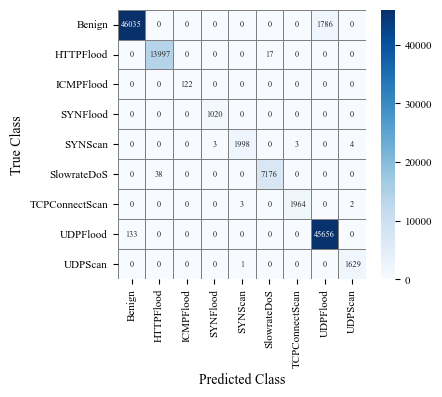

In [11]:
# arguments for evaluation function
results_file_name = 'xgboost_results.txt'
cm_title = 'XGBoost Confusion Matrix'

print("XGBoost Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_xgb, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'xgboost', accuracy, precision, recall, f1, training_time, prediction_time)

## Naive Bayes

In [12]:
# Create a Naive Bayes classifier
nb_model = GaussianNB()

# Train the model
start_time = time.time()
nb_model.fit(X_train_processed, y_train_processed)
training_time = time.time() - start_time

# Make predictions
start_time = time.time()
y_pred_nb = nb_model.predict(X_val_processed)
prediction_time = time.time() - start_time

Naive Bayes Evaluation:
Accuracy: 0.74970186
Precision: 0.83910830
Recall: 0.74970186
F1 Score: 0.73049971
Training Time: 0.0754 seconds
Prediction Time: 0.0177 seconds
latency per sample: 0.00000015 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.99655975 0.41191109 0.58289316     47821
     HTTPFlood  0.95550921 0.98080491 0.96799183     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  0.99603960 0.98627451 0.99113300      1020
       SYNScan  1.00000000 0.99103586 0.99549775      2008
   SlowrateDoS  0.95924628 0.91031328 0.93413940      7214
TCPConnectScan  0.99488229 0.98730320 0.99107826      1969
      UDPFlood  0.61285565 0.97095372 0.75142183     45789
       UDPScan  0.54646465 0.99570552 0.70565217      1630

      accuracy                      0.74970186    121587
     macro avg  0.89572860 0.91492245 0.87997860    121587
  weighted avg  0.83910830 0.74970186 0.73049971    121587



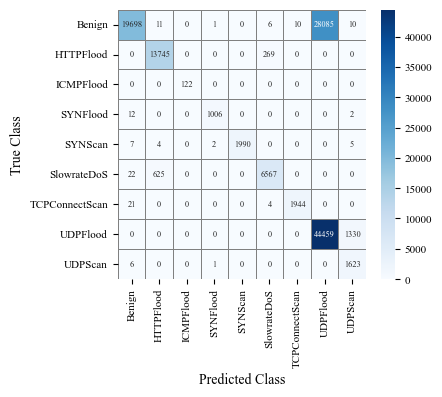

In [13]:
# arguments for evaluation function
results_file_name = 'naive_bayes_results.txt'
cm_title = 'Naive Bayes Confusion Matrix'

print("Naive Bayes Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_nb, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'naive_bayes', accuracy, precision, recall, f1, training_time, prediction_time)

## SVM

Training Kernel-Approximated SVM
Predicting...
SVM (RBF Approx) Evaluation:
Accuracy: 0.92580621
Precision: 0.96240503
Recall: 0.92580621
F1 Score: 0.94254726
Training Time: 237.3365 seconds
Prediction Time: 0.5014 seconds
latency per sample: 0.00000412 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.96639471 0.87436482 0.91807922     47821
     HTTPFlood  0.94699483 0.87583845 0.91002780     14014
     ICMPFlood  0.02507193 1.00000000 0.04891740       122
      SYNFlood  0.96637848 0.98627451 0.97622513      1020
       SYNScan  0.99949900 0.99352590 0.99650350      2008
   SlowrateDoS  0.94759110 0.96243416 0.95495495      7214
TCPConnectScan  0.98883249 0.98933469 0.98908352      1969
      UDPFlood  0.96361800 0.97929634 0.97139391     45789
       UDPScan  0.99938462 0.99631902 0.99784946      1630

      accuracy                      0.92580621    121587
     macro avg  0.86708502 0.96193199 0.86255943    121587
  weight

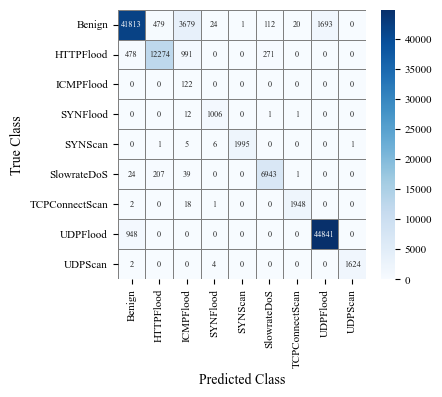

In [14]:
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline

# 1. Create a Pipeline: Map to Higher Dimension -> Then Linear Separation
# n_components=100 is a good balance. Higher = More accurate but slower.
feature_map_nystroem = Nystroem(gamma=0.2, random_state=42, n_components=100)
linear_svm = LinearSVC(dual=False, random_state=42, C=1.0, class_weight='balanced')

# Pipe them together
svm_pipeline = Pipeline([
    ("feature_map", feature_map_nystroem),
    ("svm", linear_svm)
])

# Use OneVsRest for Multi-Class (Attack Types)
ovr_classifier = OneVsRestClassifier(estimator=svm_pipeline, n_jobs=2)

# Train
print("Training Kernel-Approximated SVM")
start_time = time.time()
ovr_classifier.fit(X_train_processed, y_train_processed)
training_time = time.time() - start_time

# Predict
print("Predicting...")
start_time = time.time()
y_pred_svm = ovr_classifier.predict(X_val_processed)
prediction_time = time.time() - start_time

# Arguments for evaluation
results_file_name = 'svm_kernel_approx_results.txt'
cm_title = 'SVM (RBF Approx) Confusion Matrix'

print("SVM (RBF Approx) Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_svm, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'svm_rbf_approx', accuracy, precision, recall, f1, training_time, prediction_time)

## KNN

Training k-NN ...
Predicting k-NN ...
k-NN Evaluation:
Accuracy: 0.98137136
Precision: 0.98137241
Recall: 0.98137136
F1 Score: 0.98136921
Training Time: 0.0448 seconds
Prediction Time: 22.7210 seconds
latency per sample: 0.00018687 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.97930745 0.97580561 0.97755339     47821
     HTTPFlood  0.99338737 0.99693164 0.99515635     14014
     ICMPFlood  0.99186992 1.00000000 0.99591837       122
      SYNFlood  0.99609375 1.00000000 0.99804305      1020
       SYNScan  0.99700748 0.99551793 0.99626215      2008
   SlowrateDoS  0.99332592 0.99029665 0.99180897      7214
TCPConnectScan  0.99847561 0.99796851 0.99822200      1969
      UDPFlood  0.97557205 0.97859748 0.97708242     45789
       UDPScan  0.99877301 0.99877301 0.99877301      1630

      accuracy                      0.98137136    121587
     macro avg  0.99153473 0.99265454 0.99209108    121587
  weighted avg  0.98137241 0.9

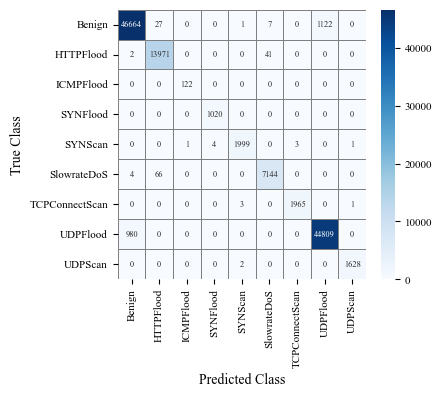

In [15]:
# Create k-NN classifier
# n_neighbors=5 is standard. n_jobs=-1 is CRITICAL for speed.
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# Train
print("Training k-NN ...")
start_time = time.time()
knn_model.fit(X_train_processed, y_train_processed)
training_time = time.time() - start_time

# Predict
# WARNING: k-NN is slow at prediction time!
print("Predicting k-NN ...")
start_time = time.time()
y_pred_knn = knn_model.predict(X_val_processed)
prediction_time = time.time() - start_time

# Evaluation
results_file_name = 'knn_results.txt'
cm_title = 'k-NN Confusion Matrix'

print("k-NN Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_knn, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'k-NN', accuracy, precision, recall, f1, training_time, prediction_time)

## Decision Tree

Training Decision Tree...
Predicting...
Decision Tree Evaluation:
Accuracy: 0.97893689
Precision: 0.97893664
Recall: 0.97893689
F1 Score: 0.97893675
Training Time: 3.7103 seconds
Prediction Time: 0.0057 seconds
latency per sample: 0.00000005 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.97404743 0.97398632 0.97401688     47821
     HTTPFlood  0.99743224 0.99785928 0.99764572     14014
     ICMPFlood  1.00000000 1.00000000 1.00000000       122
      SYNFlood  1.00000000 1.00000000 1.00000000      1020
       SYNScan  0.99800797 0.99800797 0.99800797      2008
   SlowrateDoS  0.99583796 0.99500970 0.99542366      7214
TCPConnectScan  0.99796851 0.99796851 0.99796851      1969
      UDPFlood  0.97285493 0.97289742 0.97287617     45789
       UDPScan  0.99816064 0.99877301 0.99846673      1630

      accuracy                      0.97893689    121587
     macro avg  0.99270107 0.99272247 0.99271174    121587
  weighted avg  0.97

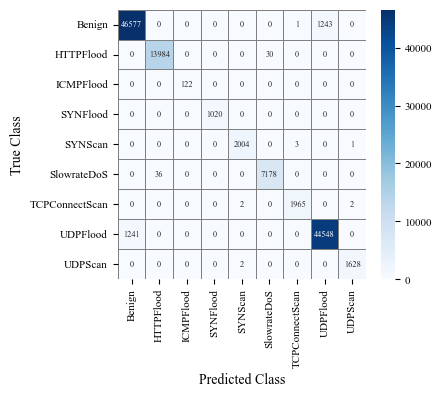

In [16]:
# Create Decision Tree
# max_depth=None means it grows fully (can overfit). 
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Train
print("Training Decision Tree...")
start_time = time.time()
dt_model.fit(X_train_processed, y_train_processed)
training_time = time.time() - start_time

# Predict
print("Predicting...")
start_time = time.time()
y_pred_dt = dt_model.predict(X_val_processed)
prediction_time = time.time() - start_time

# Evaluation
results_file_name = 'decision_tree_results.txt'
cm_title = 'Decision Tree Confusion Matrix'

print("Decision Tree Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_dt, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'decision_tree', accuracy, precision, recall, f1, training_time, prediction_time)

## MLP

Training MLP Classifier...
Iteration 1, loss = 0.09756517
Iteration 2, loss = 0.06508289
Iteration 3, loss = 0.06159448
Iteration 4, loss = 0.05974440
Iteration 5, loss = 0.05846183
Iteration 6, loss = 0.05757337
Iteration 7, loss = 0.05712787
Iteration 8, loss = 0.05633907
Iteration 9, loss = 0.05555516
Iteration 10, loss = 0.05517204
Iteration 11, loss = 0.05492574
Iteration 12, loss = 0.05447442
Iteration 13, loss = 0.05428758
Iteration 14, loss = 0.05399505
Iteration 15, loss = 0.05387485
Iteration 16, loss = 0.05357390
Iteration 17, loss = 0.05336930
Iteration 18, loss = 0.05322781
Iteration 19, loss = 0.05328773
Iteration 20, loss = 0.05310077
Iteration 21, loss = 0.05272408
Iteration 22, loss = 0.05254057
Iteration 23, loss = 0.05260033
Iteration 24, loss = 0.05237131
Iteration 25, loss = 0.05240387
Iteration 26, loss = 0.05192466
Iteration 27, loss = 0.05185898
Iteration 28, loss = 0.05174820
Iteration 29, loss = 0.05169144
Iteration 30, loss = 0.05152326
Iteration 31, loss = 0

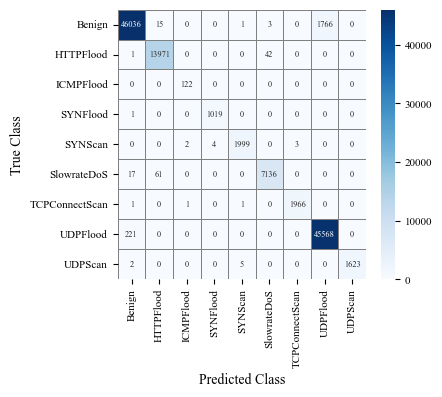

In [14]:
# Create MLP (Shallow Neural Network)
# hidden_layer_sizes=(100, 50) means 2 layers. max_iter=300 ensures convergence.
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 96, 64, 48), max_iter=300, random_state=42, activation='relu', solver='adam', alpha=0.005, verbose=True)

print("Training MLP Classifier...")
start_time = time.time()
mlp_model.fit(X_train_processed, y_train_processed)
training_time = time.time() - start_time

print("Predicting...")
start_time = time.time()
y_pred_mlp = mlp_model.predict(X_val_processed)
prediction_time = time.time() - start_time

# Evaluation
results_file_name = 'mlp_results.txt'
cm_title = 'MLP Classifier Confusion Matrix'

print("MLP Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_mlp, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'mlp', accuracy, precision, recall, f1, training_time, prediction_time)

## LDA

Training LDA...
Predicting...
LDA Evaluation:
Accuracy: 0.91098555
Precision: 0.91918881
Recall: 0.91098555
F1 Score: 0.91374368
Training Time: 0.3071 seconds
Prediction Time: 0.0040 seconds
latency per sample: 0.00000003 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.94886914 0.90186320 0.92476923     47821
     HTTPFlood  0.86898899 0.85621521 0.86255481     14014
     ICMPFlood  0.20573356 1.00000000 0.34125874       122
      SYNFlood  0.90071648 0.86274510 0.88132198      1020
       SYNScan  0.98223976 0.99153386 0.98686493      2008
   SlowrateDoS  0.63787519 0.81896313 0.71716436      7214
TCPConnectScan  0.87584345 0.98882682 0.92891221      1969
      UDPFlood  0.94688800 0.94924545 0.94806526     45789
       UDPScan  0.98658718 0.81226994 0.89098250      1630

      accuracy                      0.91098555    121587
     macro avg  0.81708242 0.90907363 0.83132156    121587
  weighted avg  0.91918881 0.91098555 0.

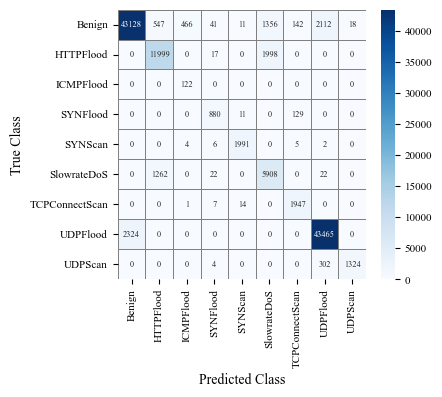

In [18]:
# Create LDA
lda_model = LinearDiscriminantAnalysis()

print("Training LDA...")
start_time = time.time()
lda_model.fit(X_train_processed, y_train_processed)
training_time = time.time() - start_time

print("Predicting...")
start_time = time.time()
y_pred_lda = lda_model.predict(X_val_processed)
prediction_time = time.time() - start_time

# Evaluation
results_file_name = 'lda_results.txt'
cm_title = 'LDA Confusion Matrix'

print("LDA Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_lda, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'lda', accuracy, precision, recall, f1, training_time, prediction_time)

## Voting Classifier

Training Voting Classifier (Ensemble)...
Predicting...
Voting Ensemble Evaluation:
Accuracy: 0.98053246
Precision: 0.98054230
Recall: 0.98053246
F1 Score: 0.98053323
Training Time: 230.0552 seconds
Prediction Time: 0.1828 seconds
latency per sample: 0.00000150 seconds

Classification Report: 
                precision    recall  f1-score   support

        Benign  0.97815677 0.97388177 0.97601459     47821
     HTTPFlood  0.99722044 0.99843014 0.99782492     14014
     ICMPFlood  0.96825397 1.00000000 0.98387097       122
      SYNFlood  0.99706745 1.00000000 0.99853157      1020
       SYNScan  0.99750374 0.99501992 0.99626028      2008
   SlowrateDoS  0.99680467 0.99459385 0.99569803      7214
TCPConnectScan  0.99898271 0.99746064 0.99822109      1969
      UDPFlood  0.97286780 0.97728712 0.97507245     45789
       UDPScan  0.99816064 0.99877301 0.99846673      1630

      accuracy                      0.98053246    121587
     macro avg  0.98944646 0.99282738 0.99110674    121587
 

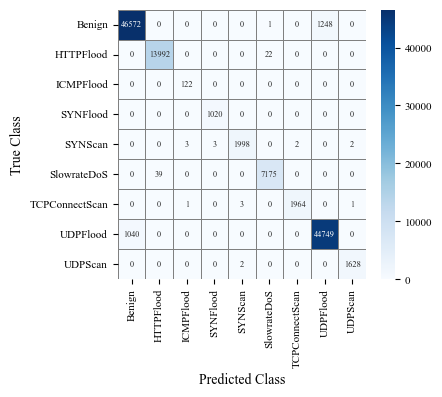

In [19]:
# 1. Define the models to combine (Estimators)
# We use the models you've already defined above (make sure to run their cells first!)
estimators = [
    ('rf', rnd_forest),
    ('xgb', xgb_model),
    ('lr', linear_model)
]

# 2. Create Voting Classifier
# voting='soft' averages the probabilities (usually better). 'hard' counts votes.
voting_model = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

print("Training Voting Classifier (Ensemble)...")
start_time = time.time()
voting_model.fit(X_train_processed, y_train_processed)
training_time = time.time() - start_time

print("Predicting...")
start_time = time.time()
y_pred_voting = voting_model.predict(X_val_processed)
prediction_time = time.time() - start_time

# Evaluation
results_file_name = 'voting_ensemble_results.txt'
cm_title = 'Voting Ensemble Confusion Matrix'

print("Voting Ensemble Evaluation:")
accuracy, precision, recall, f1 = print_evaluation_metrics(y_val_processed, y_pred_voting, training_time, prediction_time, output_encoder, results_dir, version, results_file_name, cm_title)
log_metrics(model_results, 'voting_ensemble', accuracy, precision, recall, f1, training_time, prediction_time)

# Bar charts

Saved 20F_comparison_accuracy.pdf


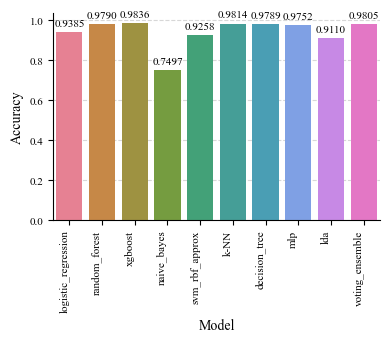

Saved 20F_comparison_precision.pdf


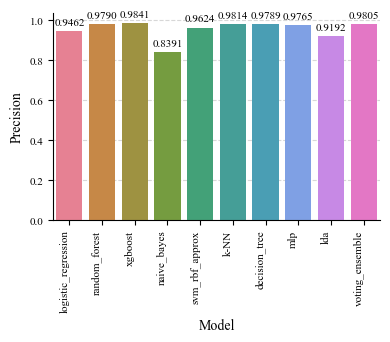

Saved 20F_comparison_recall.pdf


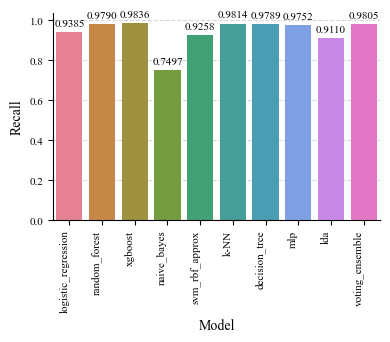

Saved 20F_comparison_f1-score.pdf


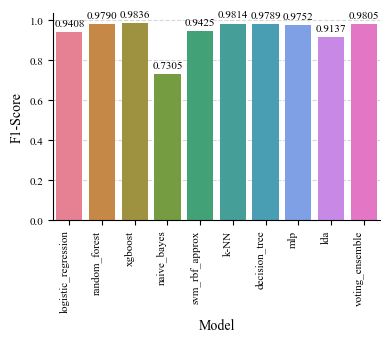

Saved 20F_comparison_training_time_s.pdf


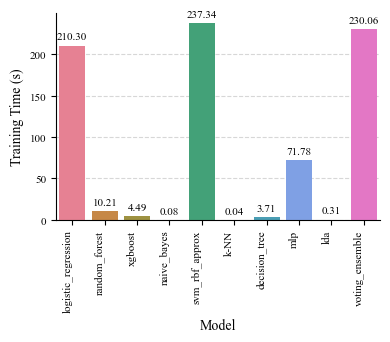

Saved 20F_comparison_prediction_time_s.pdf


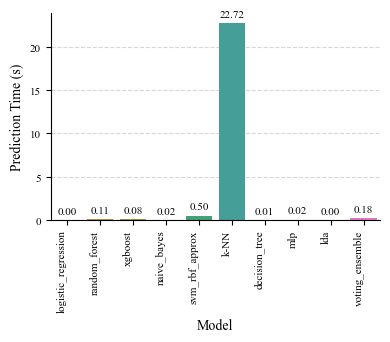

In [20]:
plot_individual_metrics(model_results, evaluation_dir, version)